In [1]:
import os
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
import tensorflow as tf

# from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.utils import Sequence

import pandas as pd
import os
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from glob import glob


In [2]:
from keras.models import Sequential, Model, load_model

In [3]:
#os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3104451953992674020,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10095296512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17602915665035401200
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.python.client import device_lib
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
def load_csvs(csv_paths, columns, dataset="mit", plot=True, rename=None):
    # dataset can be mit or nasa
    data = []
    cycles = []
    # path of directory where files are present
    for i, path in enumerate(csv_paths):
        assert os.path.exists(path)
        df = pd.read_csv(path)
        df = df[columns]
        if dataset == "mit":
            df = df[df['Step_Index'] == 10] # discharge
            df = df[df['Step_Time'] > 0] # remove outliers
            df = df[df['Step_Time'] < 5000] #remove outliers
            df = df[df["Cycle_Index"] > 0] # remove outliers
            #df = df[df["Current"] < -4.0]
            #df["Discharge_Capacity"] = df["Discharge_Capacity"].max()
            df["Discharge_Capacity"] /= 1.1
            df = df[df["Voltage"] <3.22] 
            df = df[df["Voltage"] >2.0]
            
        elif dataset == "nasa":
            if rename:
                df = df.rename(columns=rename)
            df = df[df['Voltage'] > 2.5]
            df = df[df['Voltage'] < 4.]
            df = df[df['Current_measured'] < -1.8]
            df["Voltage"] *= 0.58

            df["Step_Time"] /= 4
            df["Discharge_Capacity"] /= 2.0
        else:
            raise NotImplementedError
        data.append(df)
        cycle = df["Cycle_Index"].unique()
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
        
#     if plot:
#         plot_cycles(data, cycles)
    
    
    return data, cycles

def fit_spline(data, cycles, no_points=400, dataset="mit"):
    i = 0
    for cycle, d in zip (cycles, data):
        cell_np = []
        for index, c in enumerate (cycle):
            cycle_data = d[d["Cycle_Index"] == c]
            
            if dataset =="mit":
                cycle_data = cycle_data[cycle_data.Current < -4.0]
                cycle_data.Discharge_Capacity = cycle_data.Discharge_Capacity.max()
                cycle_data = cycle_data[cycle_data.Voltage > 2.65]
            

            #selecting part of curve that has patterns
            time, voltage, capacity, ind = cycle_data.Step_Time.values, cycle_data.Voltage, cycle_data.Discharge_Capacity, cycle_data.Cycle_Index
            time = time - time[0]
            if time.shape[0] < 100:
                continue

            # using spline function to to make dimensions of all cycles equal (to create equal number of points in every cycle)
            ius = InterpolatedUnivariateSpline(time, voltage)

            # creating linear space 0, 4000 of 100,000 points
            xi = np.linspace(0, 1000, 100000)

            #discarding points that are greater than time
            xi = xi[xi < time[-1]]
            #creating indices equal to number of points of xi and selecting 400 equidistant integers
            indices = np.linspace(0, time[-1]*100 -1, no_points).astype(int)

            #evaluating voltage for all xi
            yi = ius(xi)

            #selecting voltage at specified indices
            yi = yi[indices]

            #selecting time at specified indices
            xi = xi[indices]
            if dataset == "mit":
                if (yi > 3.3).any() or (yi < 0).any() or (yi[:100] < 3.0).any():
                    print('wrong cycle interpolation, ignore')
                    continue
            ind = np.zeros_like(xi) + ind.values[0]
            capacity = np.zeros_like(xi) + np.max(capacity)
            cell_np.append (np.array([xi, yi, capacity, ind]))
        cell_np = np.concatenate(cell_np, axis=1)
        cell_np = np.transpose (cell_np, (1,0))
        data[i] = pd.DataFrame (cell_np, columns = ['Step_Time', 'Voltage', 'Discharge_Capacity', 'Cycle_Index'])
        i+=1
        
    return data

def plot_cycles(data, cycles):
    for d, cycle in zip(data, cycles):
        for index, c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
           
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.plot(time,voltage)

    plt.show()
    


In [8]:

nasa_csvs = glob("../../usman/Capacity_data/NASA/*csv")
mit_csvs = glob("../../usman/Capacity_data/MIT/*csv")

nasa_columns = ['Time', 'cycle', 'Voltage_measured','Current_measured', 'Capacity']
mit_columns = ['Step_Time', 'Step_Index', 'Cycle_Index','Current', 'Voltage', 'Discharge_Capacity']
nasa_rename = {'Time': 'Step_Time', 'cycle': 'Cycle_Index', 'Voltage_measured': 'Voltage', "Capacity": 'Discharge_Capacity'}
print(f"Total {len(nasa_csvs)} nasa csvs")
print(f"Total {len(mit_csvs)} mit csvs")
for csv in nasa_csvs:
    print (csv)
for csv in mit_csvs:
    print (csv)

Total 5 nasa csvs
Total 10 mit csvs
../../usman/Capacity_data/NASA\B0005_discharge.csv
../../usman/Capacity_data/NASA\B0006_discharge.csv
../../usman/Capacity_data/NASA\B0007_discharge.csv
../../usman/Capacity_data/NASA\B0018_discharge.csv
../../usman/Capacity_data/NASA\B0036_discharge_corrected.csv
../../usman/Capacity_data/MIT\2017-05-12_5_4C-60per_3C_CH16.csv
../../usman/Capacity_data/MIT\2017-05-12_5_4C-80per_5_4C_CH12.csv
../../usman/Capacity_data/MIT\2017-05-12_6C-40per_3C_CH25.csv
../../usman/Capacity_data/MIT\2017-05-12_6C-40per_3C_CH26.csv
../../usman/Capacity_data/MIT\2017-05-12_6C-40per_3_6C_CH34.csv
../../usman/Capacity_data/MIT\2017-05-12_6C-50per_3_6C_CH36.csv
../../usman/Capacity_data/MIT\2017-05-12_8C-25per_3_6C_CH45.csv
../../usman/Capacity_data/MIT\2017-06-30_2C-10per_6C_CH10.csv
../../usman/Capacity_data/MIT\b1c1corrected.csv
../../usman/Capacity_data/MIT\b1c2corrected.csv


In [9]:
nasa_data, nasa_cycles = load_csvs(nasa_csvs, nasa_columns, dataset="nasa", rename=nasa_rename)
mit_data, mit_cycles = load_csvs(mit_csvs, mit_columns, dataset="mit")


total points in ../../usman/Capacity_data/NASA\B0005_discharge.csv (45072, 5)
total points in ../../usman/Capacity_data/NASA\B0006_discharge.csv (44186, 5)
total points in ../../usman/Capacity_data/NASA\B0007_discharge.csv (47798, 5)
total points in ../../usman/Capacity_data/NASA\B0018_discharge.csv (31859, 5)
total points in ../../usman/Capacity_data/NASA\B0036_discharge_corrected.csv (46164, 5)
total points in ../../usman/Capacity_data/MIT\2017-05-12_5_4C-60per_3C_CH16.csv (242428, 6)
total points in ../../usman/Capacity_data/MIT\2017-05-12_5_4C-80per_5_4C_CH12.csv (183283, 6)
total points in ../../usman/Capacity_data/MIT\2017-05-12_6C-40per_3C_CH25.csv (335532, 6)
total points in ../../usman/Capacity_data/MIT\2017-05-12_6C-40per_3C_CH26.csv (287278, 6)
total points in ../../usman/Capacity_data/MIT\2017-05-12_6C-40per_3_6C_CH34.csv (282169, 6)
total points in ../../usman/Capacity_data/MIT\2017-05-12_6C-50per_3_6C_CH36.csv (289478, 6)
total points in ../../usman/Capacity_data/MIT\2017

In [10]:
mit_data[0]

,Step_Time,Step_Index,Cycle_Index,Current,Voltage,Discharge_Capacity
514560,26.38,10.00,1.00,-4.40,3.21,0.03
514561,31.04,10.00,1.00,-4.40,3.20,0.03
514562,36.05,10.00,1.00,-4.40,3.20,0.04
514563,41.06,10.00,1.00,-4.40,3.19,0.05
514564,41.06,10.00,1.00,-4.40,3.19,0.05
...,...,...,...,...,...,...
1268864,"1,187.03",10.00,719.00,-0.05,2.00,0.80
1268865,"1,192.04",10.00,719.00,-0.05,2.00,0.80
1268866,"1,192.04",10.00,719.00,-0.05,2.00,0.80
1268867,"1,197.04",10.00,719.00,-0.05,2.00,0.80


In [11]:
print ("Fitting spline on NASA set ...")
nasa_data = fit_spline(nasa_data, nasa_cycles, dataset="nasa")

#plot_cycles(nasa_data, nasa_cycles)
print ("Fitting Split on MIT set ...")
mit_data = fit_spline(mit_data, mit_cycles, dataset="mit")
#plot_cycles(mit_data, mit_cycles)

Fitting spline on NASA set ...
Fitting Split on MIT set ...
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore


In [12]:
print(len(mit_data[0]))
print(len(mit_cycles[0]))

mit_data[0].tail()

286800
718


,Step_Time,Voltage,Discharge_Capacity,Cycle_Index
286795,584.02,2.69,0.73,719.00
286796,585.50,2.68,0.73,719.00
286797,586.98,2.68,0.73,719.00
286798,588.46,2.67,0.73,719.00
286799,589.94,2.66,0.73,719.00


In [13]:
window = 25
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 100

In [14]:
def make_data_set(data_set, window, type='train'):
    
    x_data = np.empty((0,2*window),float)
    y_data = []
    for i in range(len(data_set)):
        data = data_set[i]
        cycles = data['Cycle_Index'].unique()
        for cycle in cycles:
            step_time = data[data['Cycle_Index']==cycle].Step_Time.values
            voltage = data[data['Cycle_Index']==cycle].Voltage.values
            dc_capacity = data[data['Cycle_Index']==cycle].Discharge_Capacity.max()

            idx = np.random.randint(0,400-window)
            time_x = step_time[idx:idx+window]
            voltage_x = voltage[idx:idx+window]

            x = np.zeros((1,window*2))
            x[0,::2] = voltage_x
            x[0,1::2] = time_x
            
            x_data = np.concatenate((x_data,x),axis=0)
            y_data.append(dc_capacity)
    
    x_data = x_data.reshape((x_data.shape[0], x_data.shape[1], 1))
    y_data = np.array(y_data)

    univariate = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    if type == 'train':
        univariate = univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    elif type == 'val':
        univariate = univariate.batch(BATCH_SIZE).repeat()
    else:
        univariate = univariate.batch(BATCH_SIZE)

    return x_data, y_data, univariate

In [15]:
x_train, y_train, train_univariate = make_data_set(nasa_data[:3] + mit_data[:4],window=25)
x_val, y_val, val_univariate = make_data_set([nasa_data[3]] + [mit_data[4]],window=25,type='val')

In [16]:
x_train.shape

(3634, 50, 1)

In [17]:
x_test1, y_test1, test_univariate1 = make_data_set([nasa_data[-1]],window=25,type='test')
x_test2, y_test2, test_univariate2 = make_data_set([mit_data[6]],window=25,type='test')

# GRU model

In [18]:
dropout_ratio = 0
batch_size = 64
epoch = 100
workers=4
input_shape = x_train.shape[1:]
# GRU
model = Sequential()
model.add(GRU(128, input_shape=input_shape, return_sequences=True, activation='tanh'))
#model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="tanh"))
# model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="tanh"))
# model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="tanh"))
# model.add(Dropout(dropout_ratio)) o
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(train_univariate, validation_data=val_univariate,
                      epochs=epoch,
                       steps_per_epoch=EVALUATION_INTERVAL, validation_steps=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50, 128)           50304     
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 256)           296448    
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 128)           148224    
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 532,289
Trainable params: 532,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
200/200 [==============================] - 17s 27ms/step - loss: 0.0296 - val_loss: 0.0048
Epoch 2/100
2

In [19]:
def model_test(model, y_test, test):
    y_pred = model.predict(test)

    plt.figure(figsize=(10, 8))
    plt.plot(y_test, 'k-', label='True')
    plt.plot(y_pred, 'r', label='prediction')
    plt.legend()
    plt.show()
    print(f"Mean Absolute Error : {mean_absolute_error(y_pred, y_test):.3f}")
    print(f"Mean Squared Error(RMSE) : {mean_squared_error(y_pred, y_test, squared=False):.3f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_pred, y_test):.3f}")
    print(f"R2 Score : {r2_score(y_pred, y_test):.3f}")
    
   # return y_pred

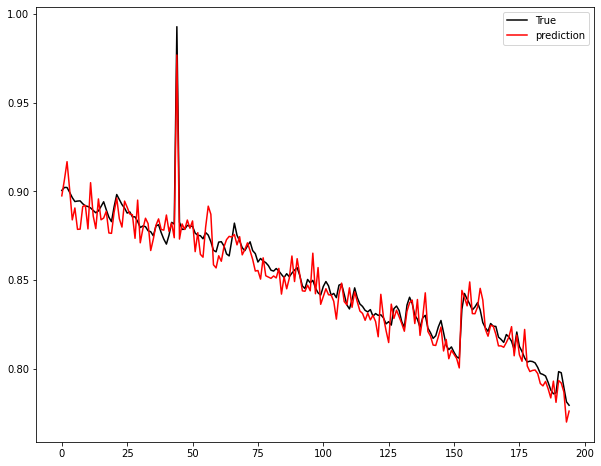

Mean Absolute Error : 0.006
Mean Squared Error(RMSE) : 0.007
MAPE: 0.006
R2 Score : 0.954


In [20]:
model_test(model, y_test1, test_univariate1)

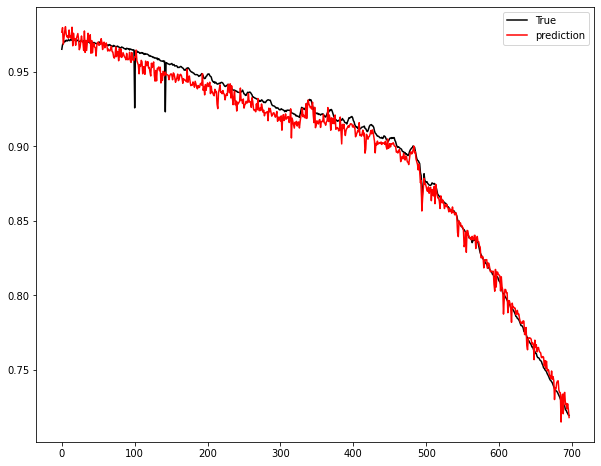

Mean Absolute Error : 0.005
Mean Squared Error(RMSE) : 0.006
MAPE: 0.006
R2 Score : 0.991


In [21]:
model_test(model, y_test2, test_univariate2)

In [22]:
NASA = model.predict(test_univariate1)
MIT = model.predict(test_univariate2)

In [23]:
pd.DataFrame(NASA).to_csv(f'./GRU_NASA_Pred.csv')
pd.DataFrame(MIT).to_csv(f'./GRU_MIT_Pred.csv')

In [ ]:
test_univariate2

In [ ]:
for x, y in train_univariate: 
    for i,curve in enumerate(x):
        plt.plot(curve[1::2], curve[::2])
plt.show()

In [ ]:
for x, y in train_univariate: 
    for i,curve in enumerate(x):
        plt.plot(curve[1::2], curve[::2])
plt.show()